![](https://fenc.wang/imgs/2020/08/3565654bfbe9ffa0.png)

In [18]:
import tushare as ts
import pandas as pd
import numpy as np
from functools import reduce
import time

#设置完整显示数据
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:,.2f}'.format)

pro = ts.pro_api('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')

In [19]:
cn_en={
    'undistr_porfit':'未分配利润',
    'money_cap':'货币资金',
    'notes_receiv':'应收票据',
    'accounts_receiv':'应收账款',
    'oth_receiv':'其他应收款',
    'inventories':'存货',
    'total_assets':'资产总计',
    'st_borr':'短期借款',
    'fcff':'企业自由现金流量',#fina_indicator
    'tr_yoy':'营业总收入同比增长率(%)',#fina_indicator
    'dt_netprofit_yoy':'扣除非经常损益同比增长率(%)', #fina_indicator
    'grossprofit_margin':'销售毛利率',#fina_indicator
    'n_cashflow_act':'经营活动产生的现金流量净额', #cashflow
    'n_income_attr_p':'净利润(不含少数股东损益)', #income
    'cfVSni':'净现比',
    'mcVSup':'货币资金与未分配利润金之比',
    'acVSta':'应收账款存货之和与总资产之比',
    'mcVSstl':'货币资金与短期借款之比',
}


指标：
1. 货币资金 与 未分配利润金之比
2. 应收账款和存货 与 总资产之比
3. 自由现金流 FCFF
4. 货币资金 与 有息负债（短期借款） 之比
5. 行业平均增速
6. 净现比：经营活动产生的现金流量净额/净利润。这个比例也是越大越好，说明净利润的含金量很高，达到1就是优秀的水平
7. 整个行业的经营活动现金流情况
8. 个股 与 行业毛利率

同行：东方日升、天合光能、中环股份、晶澳科技、爱旭股份、协鑫集成、正泰电器、航天机电、拓日新能、亿晶光电、向日葵、通威股份


In [32]:
#输入全部为股票名称或者全部为代码
#competitors = ['隆基股份','东方日升','天合光能','中环股份','晶澳科技','爱旭股份','正泰电器','拓日新能','亿晶光电']
competitors = ['隆基股份','中环股份','东方日升','天合光能']

In [33]:
stock_basic = pro.stock_basic(exchange='', list_status='L', fields='ts_code,symbol,name')

if competitors[0].isnumeric():
    stock_selections = stock_basic[stock_basic['symbol'].isin(competitors)]
else:
    stock_selections = stock_basic[stock_basic['name'].isin(competitors)]

stock_selections.head(2)

,ts_code,symbol,name
584,002129.SZ,002129,中环股份
1574,300118.SZ,300118,东方日升


In [34]:
#用于获取损益表、资产负债表、现金流量中的部分数据，这个可以参考tushare的说明来选择你想要的字段
df = pd.DataFrame()
for ts_code,name in zip(stock_selections['ts_code'], stock_selections['name']):
    indicators = pro.fina_indicator(ts_code=ts_code,fields='ts_code,end_date,fcff,tr_yoy,dt_netprofit_yoy,grossprofit_margin')
    indicators['name'] = name
    indicators['end_date'] = pd.to_datetime(indicators['end_date'], format='%Y%m%d')

    income_s = pro.income(ts_code=ts_code, fields='ts_code,end_date,n_income_attr_p')
    income_s['end_date'] = pd.to_datetime(income_s['end_date'], format='%Y%m%d')

    cf = pro.cashflow(ts_code=ts_code, fields='ts_code,end_date,n_cashflow_act')
    cf['end_date'] = pd.to_datetime(cf['end_date'], format='%Y%m%d')
    
    bs_s = pro.balancesheet(ts_code=ts_code,fields='ts_code,end_date,undistr_porfit,money_cap,notes_receiv,accounts_receiv,oth_receiv,inventories,st_borr,total_assets')
    bs_s.fillna(value=0, inplace=True)
    bs_s['end_date'] = pd.to_datetime(bs_s['end_date'], format='%Y%m%d')


    fs = [indicators, income_s, cf, bs_s]
    df = df.append(reduce(lambda left,right: pd.merge(left,right,on=['ts_code','end_date']), fs))
    df.drop_duplicates(subset=['ts_code','end_date'],keep='first',inplace=True)


In [35]:
df.head(2)

,ts_code,end_date,fcff,grossprofit_margin,dt_netprofit_yoy,tr_yoy,name,n_income_attr_p,n_cashflow_act,undistr_porfit,money_cap,notes_receiv,accounts_receiv,oth_receiv,inventories,total_assets,st_borr
0,002129.SZ,2021-03-31,"1,545,099,936.45",20.34,158.94,65.23,中环股份,"541,452,049.96","898,016,874.46","4,173,939,740.34","7,250,250,885.37","519,045,205.47","2,206,499,456.40",0.00,"2,577,356,351.70","63,359,051,840.78","1,542,000,000.00"
4,002129.SZ,2020-12-31,"2,002,036,382.00",18.85,53.48,12.85,中环股份,"1,088,995,378.47","2,858,845,789.15","3,632,487,690.38","7,515,854,433.95","395,861,423.11","2,083,737,993.60","63,458,933.34","2,144,174,858.42","58,719,683,852.40","1,692,000,000.00"


In [36]:
df['cfVSni'] = df['n_cashflow_act'].divide(df['n_income_attr_p'], fill_value=0)
df['mcVSup'] = df['money_cap'].divide(df['undistr_porfit'], fill_value=0)
df['acVSta'] = df['notes_receiv'].add(df['accounts_receiv']).add(df['oth_receiv']).add(df['inventories']).divide(df['total_assets'], fill_value=0)
df['mcVSstl'] = df['money_cap'].divide(df['st_borr'], fill_value=0)

In [37]:
df = df.rename(columns=cn_en).reset_index()

In [38]:
df.set_index('end_date', inplace=True)
df = df.fillna(0)
df_yearly = df.filter(like='12-31', axis=0)
df_yearly.head(1)

,index,ts_code,企业自由现金流量,销售毛利率,扣除非经常损益同比增长率(%),营业总收入同比增长率(%),name,净利润(不含少数股东损益),经营活动产生的现金流量净额,未分配利润,货币资金,应收票据,应收账款,其他应收款,存货,资产总计,短期借款,净现比,货币资金与未分配利润金之比,应收账款存货之和与总资产之比,货币资金与短期借款之比
end_date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,4,002129.SZ,"2,002,036,382.00",18.85,53.48,12.85,中环股份,"1,088,995,378.47","2,858,845,789.15","3,632,487,690.38","7,515,854,433.95","395,861,423.11","2,083,737,993.60","63,458,933.34","2,144,174,858.42","58,719,683,852.40","1,692,000,000.00",2.63,2.07,0.08,4.44


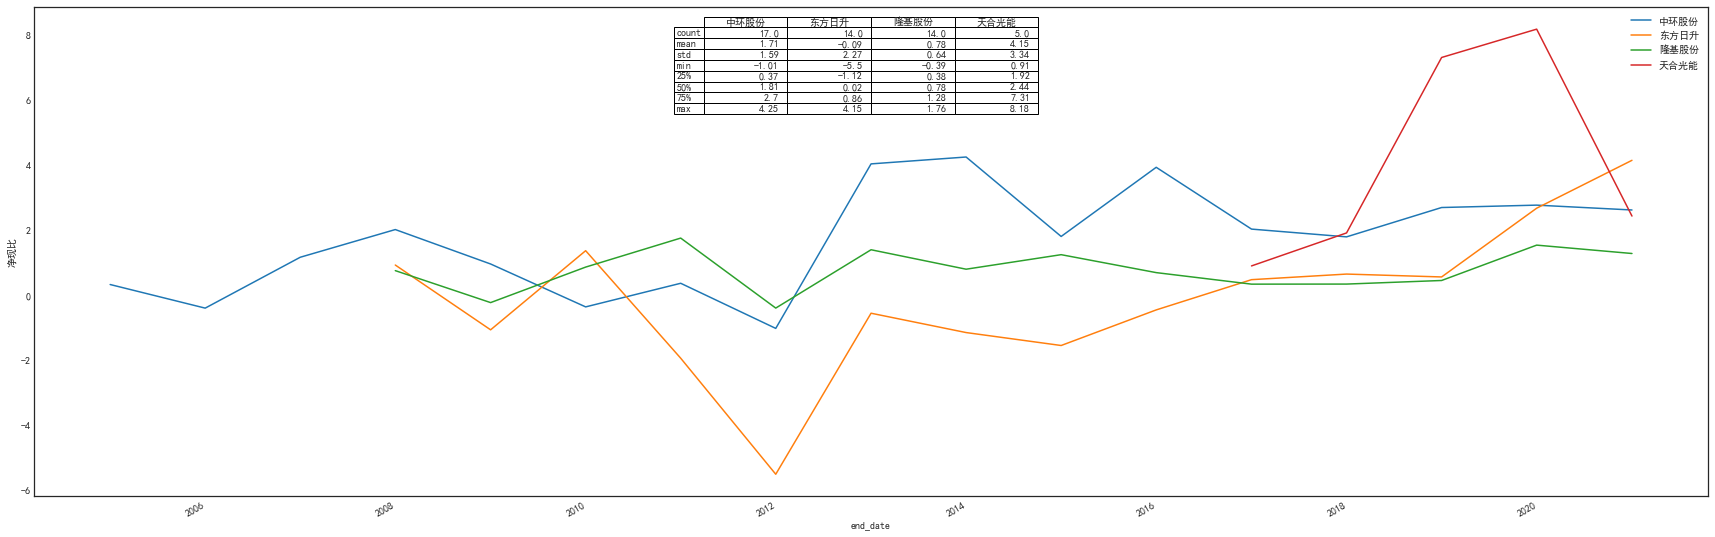

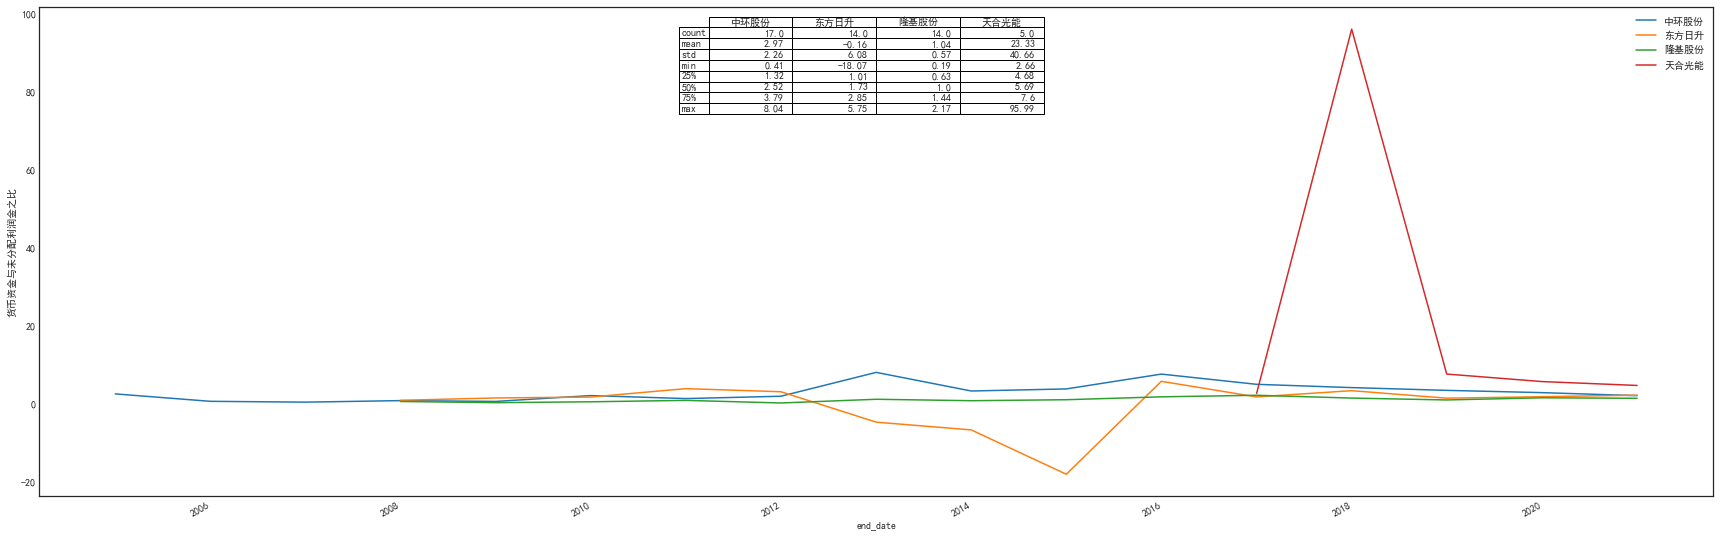

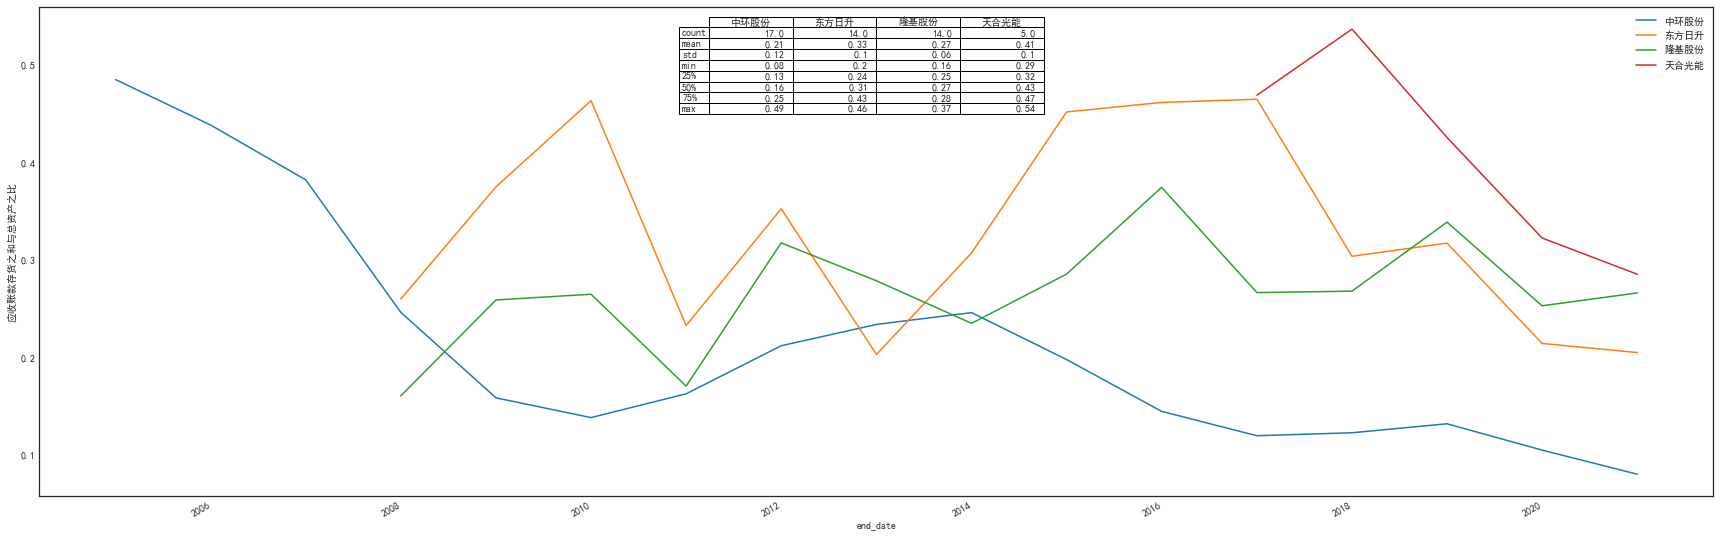

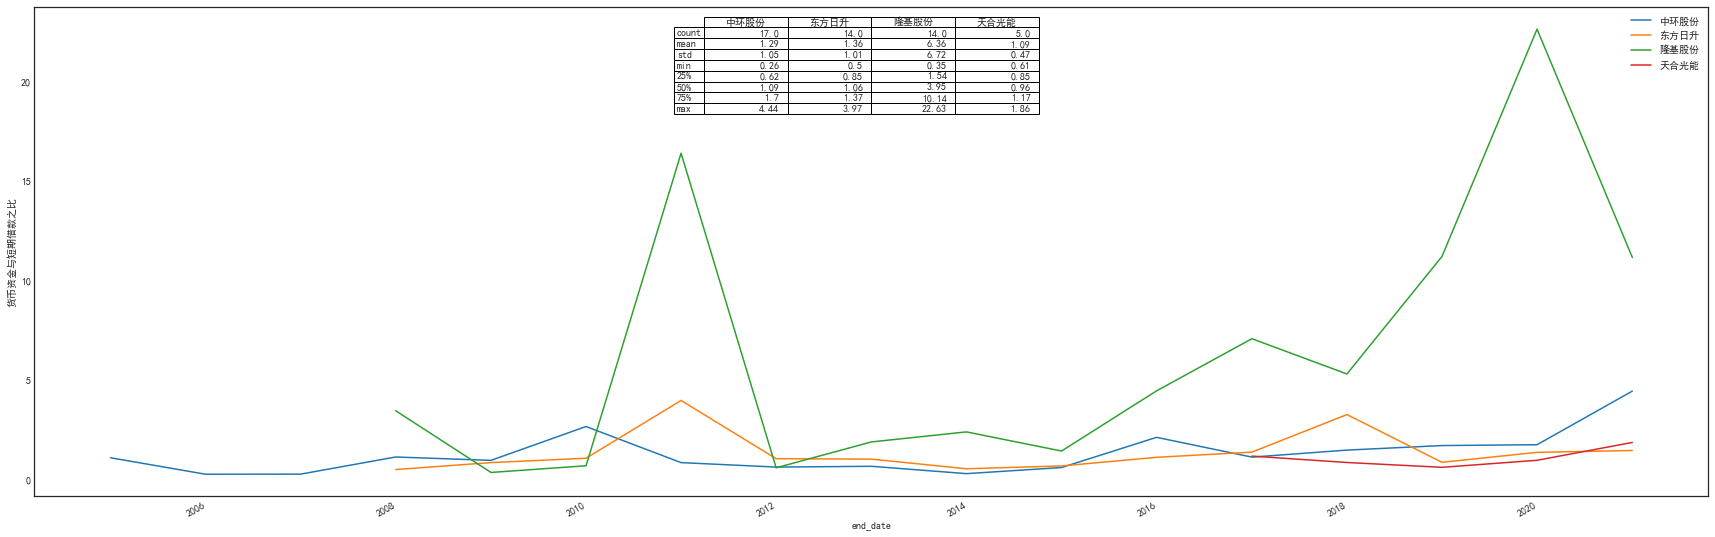

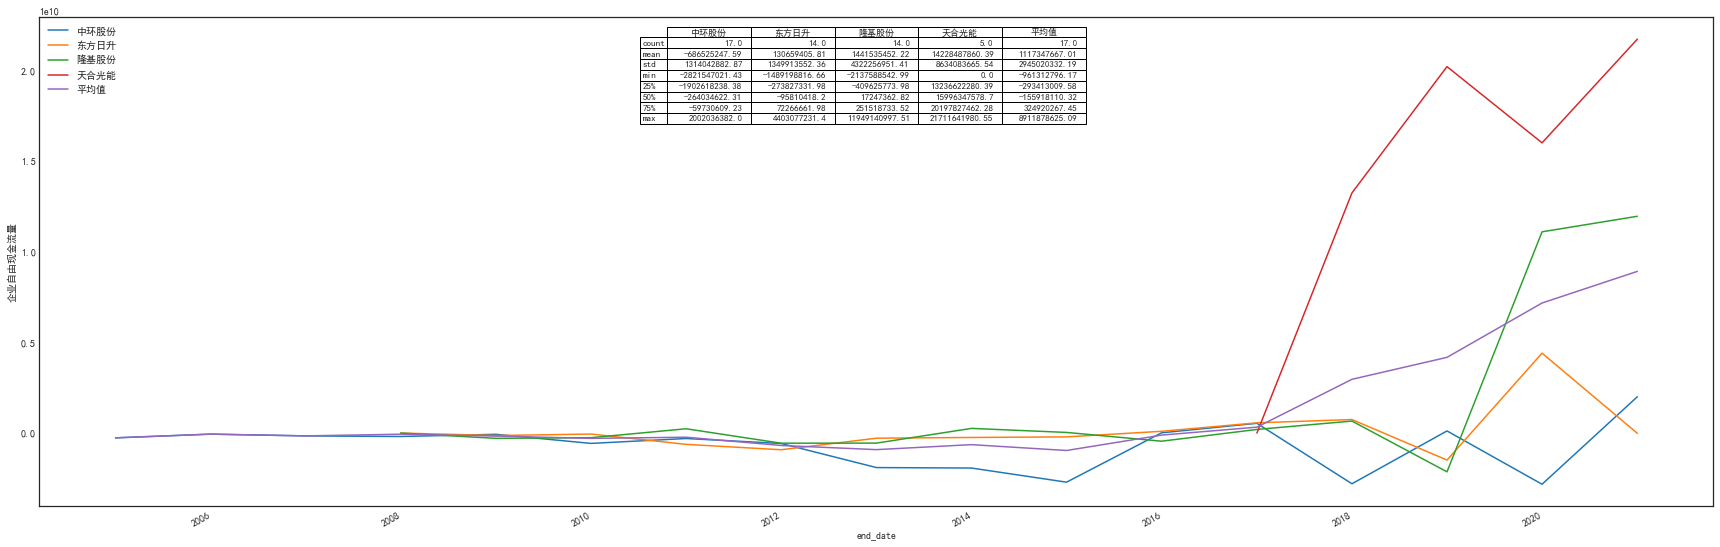

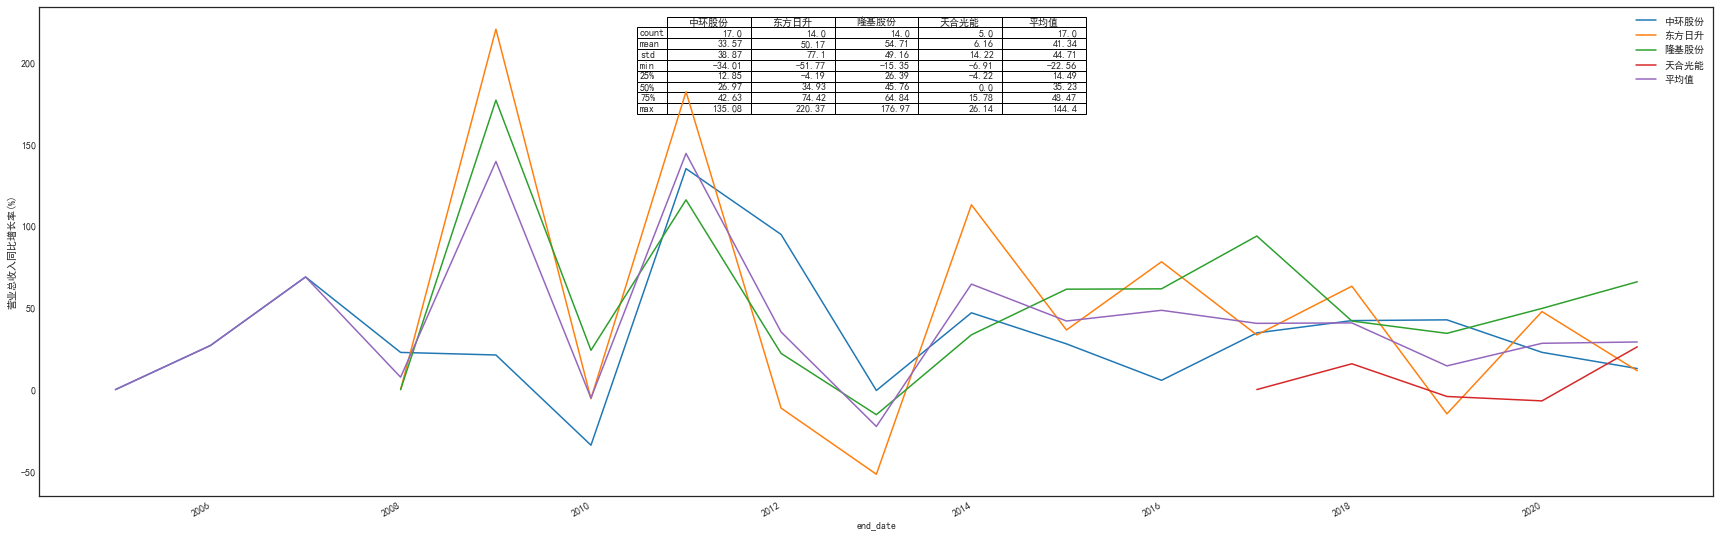

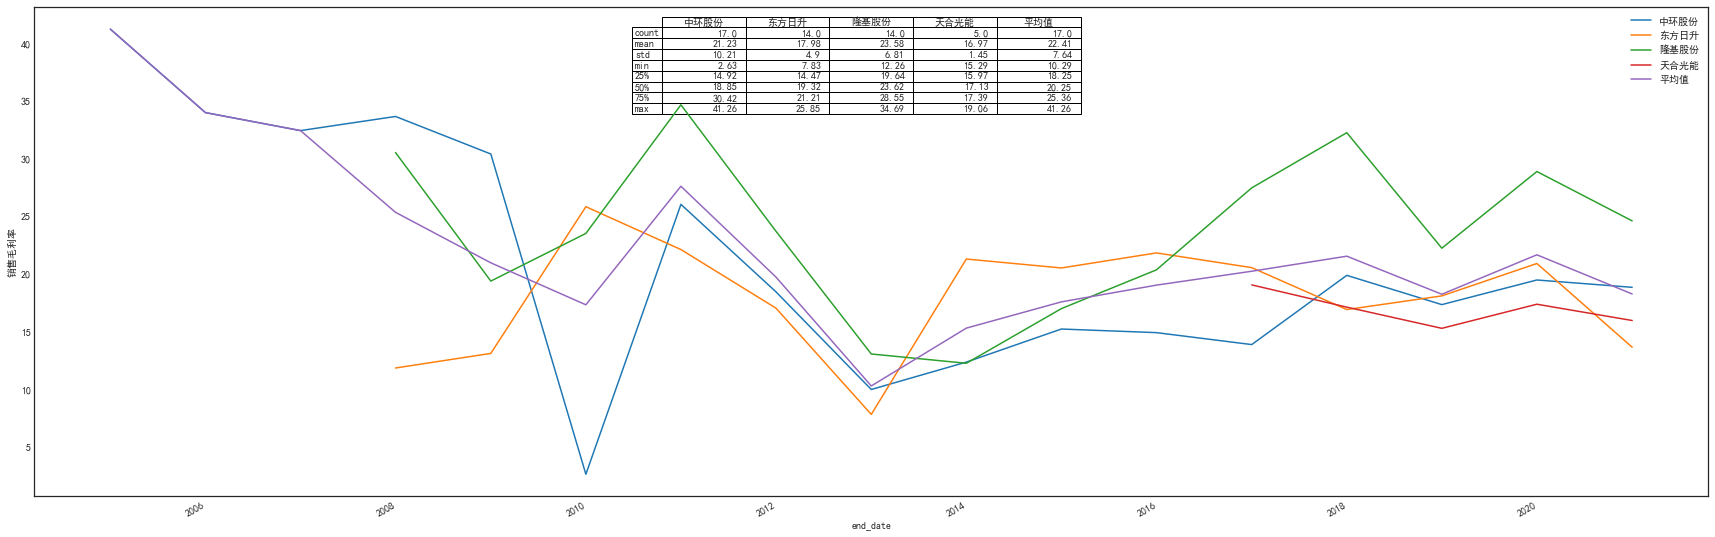

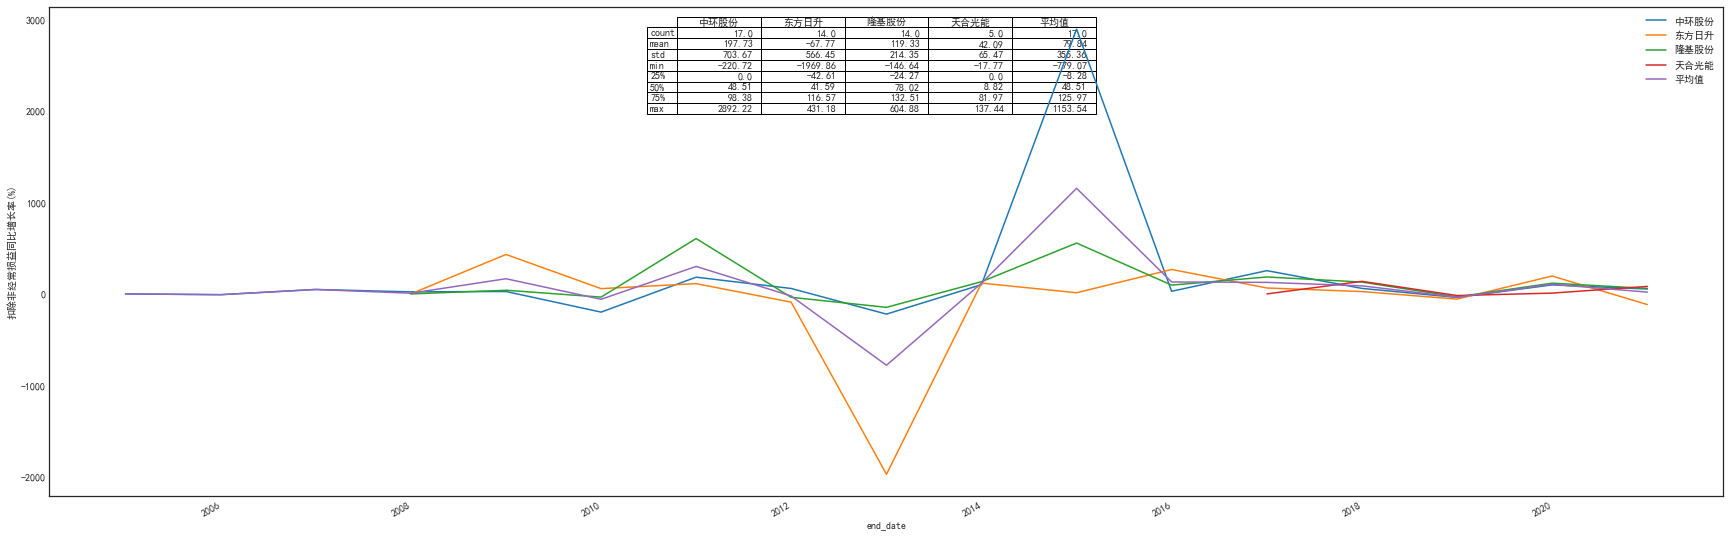

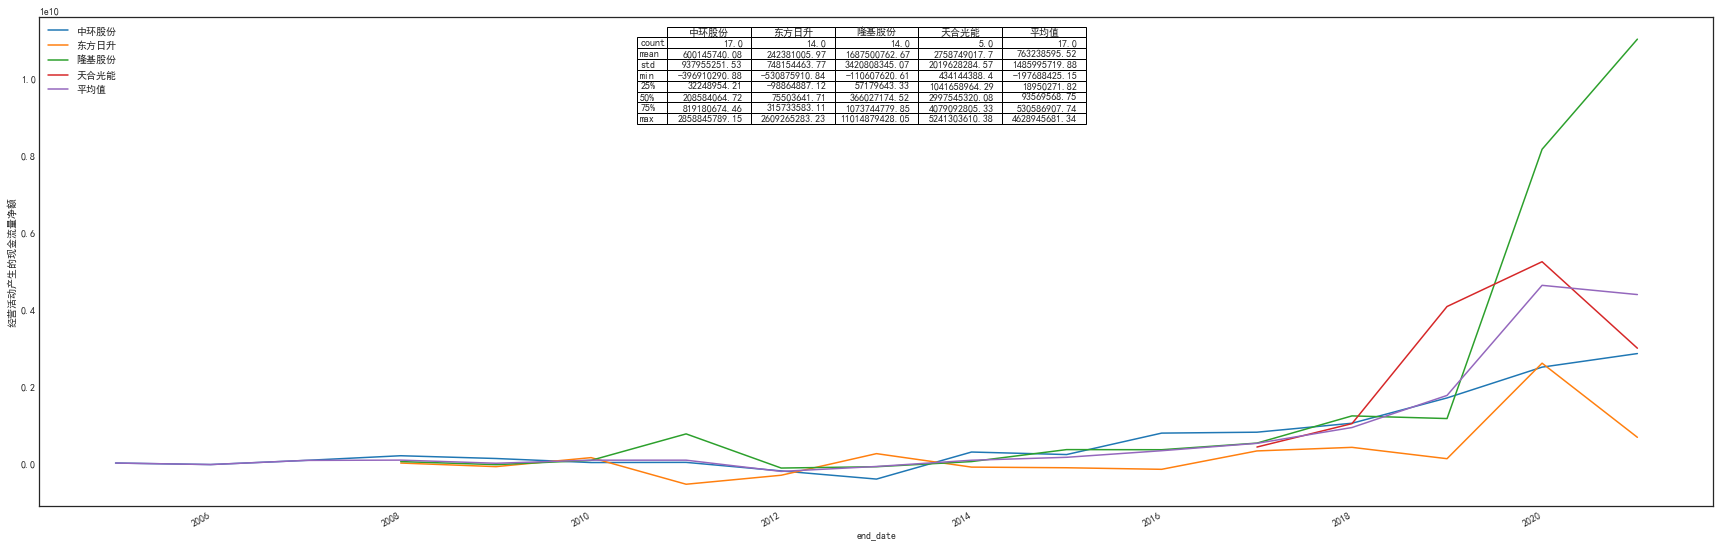

In [39]:
from pandas.plotting import table

# 导入绘图工具
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  

inds = ['净现比','货币资金与未分配利润金之比','应收账款存货之和与总资产之比','货币资金与短期借款之比']

inds_avg = ['企业自由现金流量','营业总收入同比增长率(%)','销售毛利率','扣除非经常损益同比增长率(%)','经营活动产生的现金流量净额']

for ind in inds+inds_avg:
    #先建立一个字典
    all_data ={}
    #遍历list里面的股票，可以写入多个股票
    for name in stock_selections['name']:
        #获取各股票某时段的价格
        all_data[name] = df_yearly[df_yearly['name']==name]
    #用for循环遍历股票价格并转换为dataframe的形式
    ind_data = pd.DataFrame({tic: data[ind]
                        for tic, data in all_data.items()})
    
    ind_data = ind_data.apply(pd.to_numeric)
    if ind in inds_avg:
        ind_data['平均值']= ind_data.mean(axis=1)
    colWidths = len(ind_data.columns)

    fig, ax = plt.subplots(1, 1, figsize=(30, 10))
    table(ax, np.round(ind_data.describe(), 2), loc='upper center', colWidths=[0.05]*colWidths);
    ax.set_ylabel(ind)
    ind_data.plot(ax=ax, x_compat=True)

![](https://fenc.wang/imgs/2020/08/3565654bfbe9ffa0.png)